##  Orthologs in S. cerevisiae, S. pombe + conservation score based on 9 species

**Input**: 
* cerevisiae: Orthologs from ENSEMBL, essentiality from OGEE
* pombe: Orthologs from PomBase, essentiality from Kim et al.
* other orthologs from ENSEMBL & InParanoid

**Output**: Paralog pairs annotated with ortholog features

NOTE: Treating lack of essentiality data as 'has non-essential ortholog' because most yeast genes are not essential

Single essential ortholog => single ortholog in yeast (i.e. no yeast duplicates), so a one-to-many relationship

InParanoid: http://inparanoid.sbc.su.se/cgi-bin/faq.cgi

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import itertools
import os
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({'font.size': 12, 'axes.spines.top': False, 'axes.spines.right': False, 'axes.axisbelow': True})

get_data_path = lambda folders, fname: os.path.normpath(os.environ['3RD_PARTY_DIR']+'/'+'/'.join(folders) +'/'+ fname)
get_local_data_path = lambda folders, fname: os.path.normpath('../../local_data/' +'/'.join(folders) +'/'+ fname)

# Inputs
file_unique_pairs = get_local_data_path(['processed', 'ensembl93'], 'unique_pairs.csv')
file_cerevisiae_orthologs = get_data_path(['ensembl','93'], 'cerevisiae_orthologs.txt')
file_cerevisiae_essentiality = get_data_path(['OGEE'], 'gene_essentiality.txt.gz')
file_pombe_orthologs = get_data_path(['pombase'], 'pombase-2020-07-02.human-orthologs.txt.gz')
file_pombe_deletions = get_data_path(['kim_2010'], 'pombe_gene_deletions.xls')

file_species_orthologs = get_data_path(['ensembl', '93'], 'six_species_orthologs.txt')
file_uniprot_ids = get_data_path(['ensembl', '93'], 'uniprot_ids.txt')

file_IP_cerevisiae = get_data_path(['InParanoid', 'H.sapiens-S.cerevisiae'], 'sqltable.H.sapiens-S.cerevisiae')
file_IP_pombe = get_data_path(['InParanoid', 'H.sapiens-S.pombe'], 'sqltable.H.sapiens-S.pombe')
file_IP_thaliana = get_data_path(['InParanoid','A.thaliana-H.sapiens'], 'sqltable.A.thaliana-H.sapiens')
file_IP_ecoli = get_data_path(['InParanoid','E.coli-H.sapiens'], 'sqltable.E.coli-H.sapiens')

# OUT
file_ortholog_features = get_local_data_path(['processed','paralog_features'], 'ortholog_features.csv')

In [2]:
paralog_pairs = pd.read_csv(file_unique_pairs, index_col=0)
print('Num pairs:', paralog_pairs.shape[0], ', num genes:', 
      pd.concat([paralog_pairs.A1_ensembl, paralog_pairs.A2_ensembl]).nunique())
paralog_pairs[:1]

Num pairs: 36648 , num genes: 13320


,A1,A2,min_seq_id,max_seq_id,singh_wgd,makino_wgd,WGD,same_chr,closest,family_size,family_id,cds_length_ratio,A1_entrez,A1_ensembl,A2_entrez,A2_ensembl
0,A1BG,OSCAR,0.127273,0.22028,False,False,False,True,False,3,3046,0.578629,1,ENSG00000121410,126014,ENSG00000170909


In [3]:
uniprot_ids = pd.read_csv(file_uniprot_ids).dropna()
display(uniprot_ids[:1])
uniprot_ids.columns = ['ensembl_id', 'protein_id']
uniprot_ids[:1]

,Gene stable ID,UniProtKB Gene Name ID
1,ENSG00000273875,A0A087X1Q6


,ensembl_id,protein_id
1,ENSG00000273875,A0A087X1Q6


### S. cerevisiae orthologs

2 boolean features: has cerevisiae ortholog / has essential cerevisiae ortholog

#### Ensembl

In [4]:
cerevisiae = pd.read_csv(file_cerevisiae_orthologs).dropna()
cerevisiae = cerevisiae.rename(columns={'Gene stable ID':'ensembl_id',
                                        'Saccharomyces cerevisiae gene stable ID':'cerevisiae_id',
                                        'Saccharomyces cerevisiae homology type':'homology_type'})
print('N. cerevisiae orthologs:', cerevisiae['cerevisiae_id'].nunique())
# Example of one2many - one cerevisiae gene is orthologous to three human genes
display(cerevisiae[:1])

# Call essential if essential in at least 1 study
# e.g. E & NE: http://ogee.medgenius.info/browse/Saccharomyces%2520cerevisiae/YKL122C
cerevisiae_ess = pd.read_csv(file_cerevisiae_essentiality, sep='\t')
cerevisiae_ess = cerevisiae_ess[cerevisiae_ess.sciName=='Saccharomyces cerevisiae'].reset_index(drop=True)
display(cerevisiae_ess[:1])
cerevisiae_ess['essential'] = cerevisiae_ess.essential =='E'
cerevisiae_ess = cerevisiae_ess.groupby('locus').essential.max().reset_index().rename(columns={'locus':'cerevisiae_id'})
print('cerevisiae genes that are essential: %.2f%%' % (sum(cerevisiae_ess.essential)/cerevisiae_ess.shape[0]*100))
display(cerevisiae_ess[:1])

# Merge essentiality info with orthologs
cerevisiae = pd.merge(cerevisiae[['ensembl_id', 'cerevisiae_id', 'homology_type']], cerevisiae_ess)

# Look at homology types for essential orthologs
print('Homology types for essential orthologs:\n',
      cerevisiae[cerevisiae.essential].drop_duplicates(subset=['cerevisiae_id'])['homology_type'].value_counts(), sep='')

N. cerevisiae orthologs: 1146


,ensembl_id,cerevisiae_id,homology_type
3,ENSG00000013503,YOR207C,ortholog_one2many


,sciName,kingdom,datasetID,locus,essential,pubmedID,taxID,thumbup,thumbdown,valid,fitnessScore,id
0,Saccharomyces cerevisiae,eukaryota,350,Q0045,NE,0,4932,0,0,0,-1.0,3834


cerevisiae genes that are essential: 19.39%


,cerevisiae_id,essential
0,Q0045,False


Homology types for essential orthologs:
ortholog_one2many     253
ortholog_many2many     17
ortholog_one2one        1
Name: homology_type, dtype: int64


In [5]:
# One-to-many relationship can be in either direction, 
# i.e. 1 human gene to many cerevisiae genes or 1 cerevisiae gene to many human genes
display(cerevisiae[(cerevisiae.homology_type=='ortholog_one2many') & (cerevisiae.cerevisiae_id=='YLR142W')])

,ensembl_id,cerevisiae_id,homology_type,essential
2844,ENSG00000277196,YLR142W,ortholog_one2many,False
2845,ENSG00000250799,YLR142W,ortholog_one2many,False
2846,ENSG00000100033,YLR142W,ortholog_one2many,False


In [6]:
cerevisiae_essential = cerevisiae[cerevisiae.essential==True].reset_index(drop=True)
cerevisiae_single_essential = cerevisiae_essential[cerevisiae_essential.homology_type!='ortholog_many2many']
# Check that no Ensembl IDs are duplicated
assert(cerevisiae_single_essential[cerevisiae_single_essential.duplicated(subset=['ensembl_id'], keep=False)].shape[0]==0)

#### InParanoid
- Seed-ortholog pair refers to the two seed members that are orthologous to each other, around which their inparalogs are clustered
- Each member of the cluster receives an inparalog score, which reflects the relative distance to the seed-inparalog (1.0=identical to the seed-inparalog; 0.0=of equal distance to the seed-inparalog as the distance between the seed-ortholog pair)
- Each cluster is a set of orthologs/paralogs; size of cluster indicates one2one/one2many/many2many relationship

In [7]:
# InParanoid could have different human paralogs (inparalogs that we don't call paralogs)
def read_inparanoid_file(fname, inparalog_score=0.5):
    inparanoid = pd.read_csv(fname, sep='\t', names=['cluster', 'unknown', 'species', 'score', 'protein_id', 'bootstrap'])
    inparanoid = inparanoid.drop(columns=['unknown'])
    #display(inparanoid[:2])
    
    # Merge ensembl IDs for human proteins - multiple ensembl IDs can match to same protein?
    inparanoid = pd.merge(inparanoid, uniprot_ids, how='left')
    # Drop human genes that don't have an ensembl id
    inparanoid = inparanoid[~((inparanoid.species=='H.sapiens') & (inparanoid.ensembl_id.isna()))].reset_index(drop=True)
    
    # Drop clusters of size 1 (no human ortholog left for the cerevisiae gene)
    cluster_sizes = inparanoid.cluster.value_counts()
    inparanoid = inparanoid[inparanoid.cluster.isin(cluster_sizes[cluster_sizes>1].index)].reset_index(drop=True)
    
    for s in [0, 0.5]:
        print('N orthologs at score=',s,': ', 
          inparanoid[(inparanoid.species!='H.sapiens') & (inparanoid.score>=s)].protein_id.nunique(), sep='')
        
    inparanoid = inparanoid[inparanoid.score >= inparalog_score].reset_index(drop=True)
    
    return inparanoid

In [8]:
cerevisiae_ip = read_inparanoid_file(file_IP_cerevisiae, inparalog_score=0.5)
cerevisiae_ip[:2]

N orthologs at score=0: 2356
N orthologs at score=0.5: 2169


,cluster,species,score,protein_id,bootstrap,ensembl_id
0,1,H.sapiens,1.0,Q6P2Q9,100%,ENSG00000174231
1,1,H.sapiens,1.0,Q6P2Q9,100%,ENSG00000274442


#### All cerevisiae features

In [9]:
# Assign features to each paralog pair
cerevisiae_features = paralog_pairs[['A1','A2']].assign(
    has_cerevisiae_ortholog = 
        (paralog_pairs.A1_ensembl.isin(cerevisiae.ensembl_id) | paralog_pairs.A2_ensembl.isin(cerevisiae.ensembl_id)),
    has_essential_cerevisiae_ortholog = 
        (paralog_pairs.A1_ensembl.isin(cerevisiae_essential.ensembl_id) | 
         paralog_pairs.A2_ensembl.isin(cerevisiae_essential.ensembl_id)),
    has_single_essential_cerevisiae_ortholog = 
        (paralog_pairs.A1_ensembl.isin(cerevisiae_single_essential.ensembl_id) | 
         paralog_pairs.A2_ensembl.isin(cerevisiae_single_essential.ensembl_id)),
    has_cerevisiae_ortholog_ip = 
        (paralog_pairs.A1_ensembl.isin(cerevisiae_ip.ensembl_id) | paralog_pairs.A2_ensembl.isin(cerevisiae_ip.ensembl_id))
)

print('Pairs w/ single / essential / cerevisiae ortholog:', 
      sum(cerevisiae_features.has_single_essential_cerevisiae_ortholog), '/',
      sum(cerevisiae_features.has_essential_cerevisiae_ortholog), '/',
      sum(cerevisiae_features.has_cerevisiae_ortholog))
print('Pairs w/ InParanoid cerevisiae ortholog:', sum(cerevisiae_features.has_cerevisiae_ortholog_ip))
cerevisiae_features[:2]

Pairs w/ single / essential / cerevisiae ortholog: 2035 / 2430 / 8172
Pairs w/ InParanoid cerevisiae ortholog: 4183


,A1,A2,has_cerevisiae_ortholog,has_essential_cerevisiae_ortholog,has_single_essential_cerevisiae_ortholog,has_cerevisiae_ortholog_ip
0,A1BG,OSCAR,False,False,False,False
1,A1BG,TARM1,False,False,False,False


### S. pombe orthologs

#### PomBase

In [10]:
pombe = pd.read_csv(file_pombe_orthologs, sep='\t', names=['pombe_id','human_symbol'])
pombe = pombe[pombe.human_symbol != 'NONE'].reset_index(drop=True)
display(pombe[2:3])

# Expand human genes, they are delimited with | (=multiple orthologs for a pombe gene, one2many)
df = pombe.set_index('pombe_id').human_symbol.apply(lambda x: pd.Series(x.split('|'))).stack()\
          .reset_index().drop(columns=['level_1']).rename(columns={0:'human_symbol'})
assert(pombe.shape[0] + pombe.human_symbol.apply(lambda x: x.count('|')).sum() == df.shape[0])
pombe = df
display(pombe[2:4])

# E = essential, V = viable (not essential) in Analysis dataset column
pombe_ess = pd.read_excel(file_pombe_deletions)
pombe_ess = pombe_ess.rename(columns={'Analysis dataset':'essentiality', 'Systemic ID':'pombe_id'})
pombe_ess = pombe_ess[['pombe_id', 'essentiality']].dropna(subset=['essentiality'])
pombe_ess['essential'] = pombe_ess.essentiality=='E'
print('N pombe orthologs with essentiality:', pombe_ess[pombe_ess.pombe_id.isin(pombe.pombe_id)].shape[0], 
      '/', pombe.pombe_id.nunique())
print('pombe genes that are essential: %.2f%%' % (sum(pombe_ess.essential)/pombe_ess.shape[0]*100))
display(pombe_ess[:1])

# Merge essentiality info with orthologs
pombe = pd.merge(pombe, pombe_ess[['pombe_id','essential']], how='left').fillna({'essential':False})
print('N. essential pombe genes:', pombe[pombe.essential].pombe_id.nunique(), '/', pombe.pombe_id.nunique())
display(pombe[:2])

# Essential pombe orthologs
pombe_essential = pombe[pombe.essential].reset_index(drop=True)

,pombe_id,human_symbol
2,SPAC1002.05c,KDM5D|KDM5C|KDM5B|KDM5A


,pombe_id,human_symbol
2,SPAC1002.05c,KDM5D
3,SPAC1002.05c,KDM5C


N pombe orthologs with essentiality: 3434 / 3534
pombe genes that are essential: 26.05%


,pombe_id,essentiality,essential
0,SPAC1002.01,V,False


N. essential pombe genes: 1116 / 3534


,pombe_id,human_symbol,essential
0,SPAC1002.03c,GANAB,False
1,SPAC1002.04c,TAF11,True


In [11]:
# Merge pombe info with paralog pairs (for each gene)
df1 = pd.merge(paralog_pairs[['A1','A2']], pombe.rename(columns={'human_symbol':'A1'}))
df2 = pd.merge(paralog_pairs[['A1','A2']], pombe.rename(columns={'human_symbol':'A2'}))
df = pd.concat([df1,df2]).drop_duplicates()
# For each pair, count number of pombe orthologs and whether any of those ortholog are essential
df = df.groupby(['A1','A2']).agg({'pombe_id':'nunique','essential':'max'}).reset_index().rename(columns={'pombe_id':'n_pombe'})

# Only keep pairs with single essential
w_pombe_single_essential = df[(df.n_pombe==1) & (df.essential==True)]
w_pombe_single_essential = w_pombe_single_essential.drop(columns=['n_pombe','essential']).reset_index(drop=True)
w_pombe_single_essential['has_single_essential_pombe_ortholog'] = True
print('N pairs with single essential pombe ortholog:', w_pombe_single_essential.shape[0])
w_pombe_single_essential[:1]

N pairs with single essential pombe ortholog: 1062


,A1,A2,has_single_essential_pombe_ortholog
0,AARS1,AARS2,True


#### InParanoid

In [12]:
pombe_ip = read_inparanoid_file(file_IP_pombe, inparalog_score=0.5)
pombe_ip[:2]

N orthologs at score=0: 2445
N orthologs at score=0.5: 2321


,cluster,species,score,protein_id,bootstrap,ensembl_id
0,1,H.sapiens,1.0,Q6P2Q9,100%,ENSG00000174231
1,1,H.sapiens,1.0,Q6P2Q9,100%,ENSG00000274442


#### All pombe features

In [13]:
# Assign features to each paralog pair
pombe_features = paralog_pairs[['A1','A2']].assign(
    has_pombe_ortholog = 
        (paralog_pairs.A1.isin(pombe.human_symbol) | paralog_pairs.A2.isin(pombe.human_symbol)),
    has_essential_pombe_ortholog = 
        (paralog_pairs.A1.isin(pombe_essential.human_symbol) | paralog_pairs.A2.isin(pombe_essential.human_symbol)),
    has_pombe_ortholog_ip = 
       (paralog_pairs.A1_ensembl.isin(pombe_ip.ensembl_id) | paralog_pairs.A2_ensembl.isin(pombe_ip.ensembl_id))
)

# Merge pairs with single essential pombe ortholog
pombe_features = pd.merge(pombe_features, w_pombe_single_essential, how='left')
pombe_features = pombe_features.fillna({'has_single_essential_pombe_ortholog':False})

print('\nPairs w/ single / essential / pombe ortholog:', 
      sum(pombe_features.has_single_essential_pombe_ortholog), '/', 
      sum(pombe_features.has_essential_pombe_ortholog), '/', 
      sum(pombe_features.has_pombe_ortholog))
print('Pairs w/ InParanoid pombe ortholog:', sum(pombe_features.has_pombe_ortholog_ip))
pombe_features[:2]


Pairs w/ single / essential / pombe ortholog: 1062 / 1667 / 5757
Pairs w/ InParanoid pombe ortholog: 4774


,A1,A2,has_pombe_ortholog,has_essential_pombe_ortholog,has_pombe_ortholog_ip,has_single_essential_pombe_ortholog
0,A1BG,OSCAR,False,False,False,False
1,A1BG,TARM1,False,False,False,False


### E. coli

In [14]:
ecoli_orthologs = read_inparanoid_file(file_IP_ecoli, inparalog_score=0.5)
ecoli_features = paralog_pairs[['A1_ensembl','A2_ensembl']].assign(
    has_ecoli_ortholog = (paralog_pairs.A1_ensembl.isin(ecoli_orthologs.ensembl_id) | 
                          paralog_pairs.A2_ensembl.isin(ecoli_orthologs.ensembl_id))
)
print('Pairs w/ inparanoid E. coli ortholog:', sum(ecoli_features.has_ecoli_ortholog))
ecoli_features[:2]

N orthologs at score=0: 620
N orthologs at score=0.5: 545
Pairs w/ inparanoid E. coli ortholog: 723


,A1_ensembl,A2_ensembl,has_ecoli_ortholog
0,ENSG00000121410,ENSG00000170909,False
1,ENSG00000121410,ENSG00000248385,False


### A. thaliana

In [15]:
thaliana_orthologs = read_inparanoid_file(file_IP_thaliana, inparalog_score=0.5)
thaliana_features = paralog_pairs[['A1_ensembl','A2_ensembl']].assign(
    has_thaliana_ortholog = (paralog_pairs.A1_ensembl.isin(thaliana_orthologs.ensembl_id) | 
                             paralog_pairs.A2_ensembl.isin(thaliana_orthologs.ensembl_id))
)
print('Pairs w/ inparanoid A. thaliana ortholog:', sum(thaliana_features.has_thaliana_ortholog))
thaliana_features[:2]

N orthologs at score=0: 7497
N orthologs at score=0.5: 4564
Pairs w/ inparanoid A. thaliana ortholog: 7471


,A1_ensembl,A2_ensembl,has_thaliana_ortholog
0,ENSG00000121410,ENSG00000170909,False
1,ENSG00000121410,ENSG00000248385,False


### Conservation score

Based on orthologs from 9 species:
- S. cerevisiae
- Drosophila (fruitfly)
- Mouse
- C. elegans
- Zebrafish
- Xenopus (tropical clawed frog)
- Rat
- Thale cress (InParanoid)
- E. coli (InParanoid)

In [16]:
species_orthologs_raw = pd.read_csv(file_species_orthologs, low_memory=False)
species_orthologs_raw[1:2]

,Gene stable ID,Caenorhabditis elegans gene stable ID,Fruitfly gene stable ID,Mouse gene stable ID,Rat gene stable ID,Xenopus gene stable ID,Zebrafish gene stable ID
1,ENSG00000276345,WBGene00020348,FBgn0035335,ENSMUSG00000037772,ENSRNOG00000020354,ENSXETG00000014017,ENSDARG00000045696


In [17]:
orthologs = species_orthologs_raw.groupby('Gene stable ID').agg(lambda x: ~x.isna().all()).reset_index()

# Merge cerevisiae orthologs (also from Ensembl)
cerevisiae_orthologs = pd.read_csv(file_cerevisiae_orthologs)[['Gene stable ID', 'Saccharomyces cerevisiae gene stable ID']]
cerevisiae_orthologs = cerevisiae_orthologs.groupby('Gene stable ID').agg(lambda x: ~x.isna().all()).reset_index()
orthologs = pd.merge(orthologs, cerevisiae_orthologs, how="outer").rename(columns={'Gene stable ID':'ensembl_id'})
display(orthologs[:1])

# Add E. coli and thale cress orthologs from InParanoid
orthologs = orthologs.assign(thale_cress = orthologs.ensembl_id.isin(thaliana_orthologs.ensembl_id),
                             e_coli = orthologs.ensembl_id.isin(ecoli_orthologs.ensembl_id))

n_species = orthologs.shape[1]-1
display(orthologs[:1])
print('N:', orthologs.shape[0])
print('N species:', n_species)

,ensembl_id,Caenorhabditis elegans gene stable ID,Fruitfly gene stable ID,Mouse gene stable ID,Rat gene stable ID,Xenopus gene stable ID,Zebrafish gene stable ID,Saccharomyces cerevisiae gene stable ID
0,ENSG00000000003,False,False,True,True,True,True,False


,ensembl_id,Caenorhabditis elegans gene stable ID,Fruitfly gene stable ID,Mouse gene stable ID,Rat gene stable ID,Xenopus gene stable ID,Zebrafish gene stable ID,Saccharomyces cerevisiae gene stable ID,thale_cress,e_coli
0,ENSG00000000003,False,False,True,True,True,True,False,False,False


N: 14532
N species: 9


In [18]:
# Conversation score = number of species in which at least one paralog has an ortholog
# Merge independently on each gene in paralog pair
df1 = pd.merge(paralog_pairs[['A1_ensembl','A2_ensembl']], orthologs.rename(columns={'ensembl_id':'A1_ensembl'}))
df2 = pd.merge(paralog_pairs[['A1_ensembl','A2_ensembl']], orthologs.rename(columns={'ensembl_id':'A2_ensembl'}))
df = pd.concat([df1, df2])

# Indicates whether either gene has an ortholog in each species
df = df.groupby(['A1_ensembl','A2_ensembl']).max().reset_index()
display(df[:1])

df['conservation_score'] = df.iloc[:, 2:].sum(axis=1)
conservation = df[['A1_ensembl','A2_ensembl','conservation_score']]
print('Pairs conserved in all 9 species:', conservation[conservation.conservation_score==9].shape[0])
print('Avg. conservation score:', conservation.conservation_score.mean())
display(conservation[:1])

,A1_ensembl,A2_ensembl,Caenorhabditis elegans gene stable ID,Fruitfly gene stable ID,Mouse gene stable ID,Rat gene stable ID,Xenopus gene stable ID,Zebrafish gene stable ID,Saccharomyces cerevisiae gene stable ID,thale_cress,e_coli
0,ENSG00000000003,ENSG00000156298,False,False,True,True,True,True,False,False,False


Pairs conserved in all 9 species: 260
Avg. conservation score: 4.812404496834752


,A1_ensembl,A2_ensembl,conservation_score
0,ENSG00000000003,ENSG00000156298,4


### Merge and export

In [20]:
ortholog_features = pd.merge(paralog_pairs[['A1','A2','A1_ensembl','A2_ensembl']], cerevisiae_features)
ortholog_features = pd.merge(ortholog_features, pombe_features)
ortholog_features = pd.merge(ortholog_features, ecoli_features)
ortholog_features = pd.merge(ortholog_features, conservation)
assert(ortholog_features.shape[0] == paralog_pairs.shape[0])
ortholog_features[:1]

,A1,A2,A1_ensembl,A2_ensembl,has_cerevisiae_ortholog,has_essential_cerevisiae_ortholog,has_single_essential_cerevisiae_ortholog,has_cerevisiae_ortholog_ip,has_pombe_ortholog,has_essential_pombe_ortholog,has_pombe_ortholog_ip,has_single_essential_pombe_ortholog,has_ecoli_ortholog,conservation_score
0,A1BG,OSCAR,ENSG00000121410,ENSG00000170909,False,False,False,False,False,False,False,False,False,3


In [22]:
ortholog_features.to_csv(file_ortholog_features, index=0)

Text(0, 0.5, 'Num. paralog pairs')

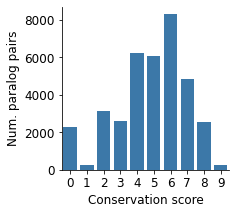

In [23]:
f, ax = plt.subplots(1, 1, figsize=(3,3))
sns.countplot(x=ortholog_features.conservation_score, ax=ax, color=sns.color_palette('Blues')[4])
ax.set_xlabel('Conservation score'); ax.set_ylabel('Num. paralog pairs')